0.9551374912261963
0.0293397456407547
0.0465839009739452


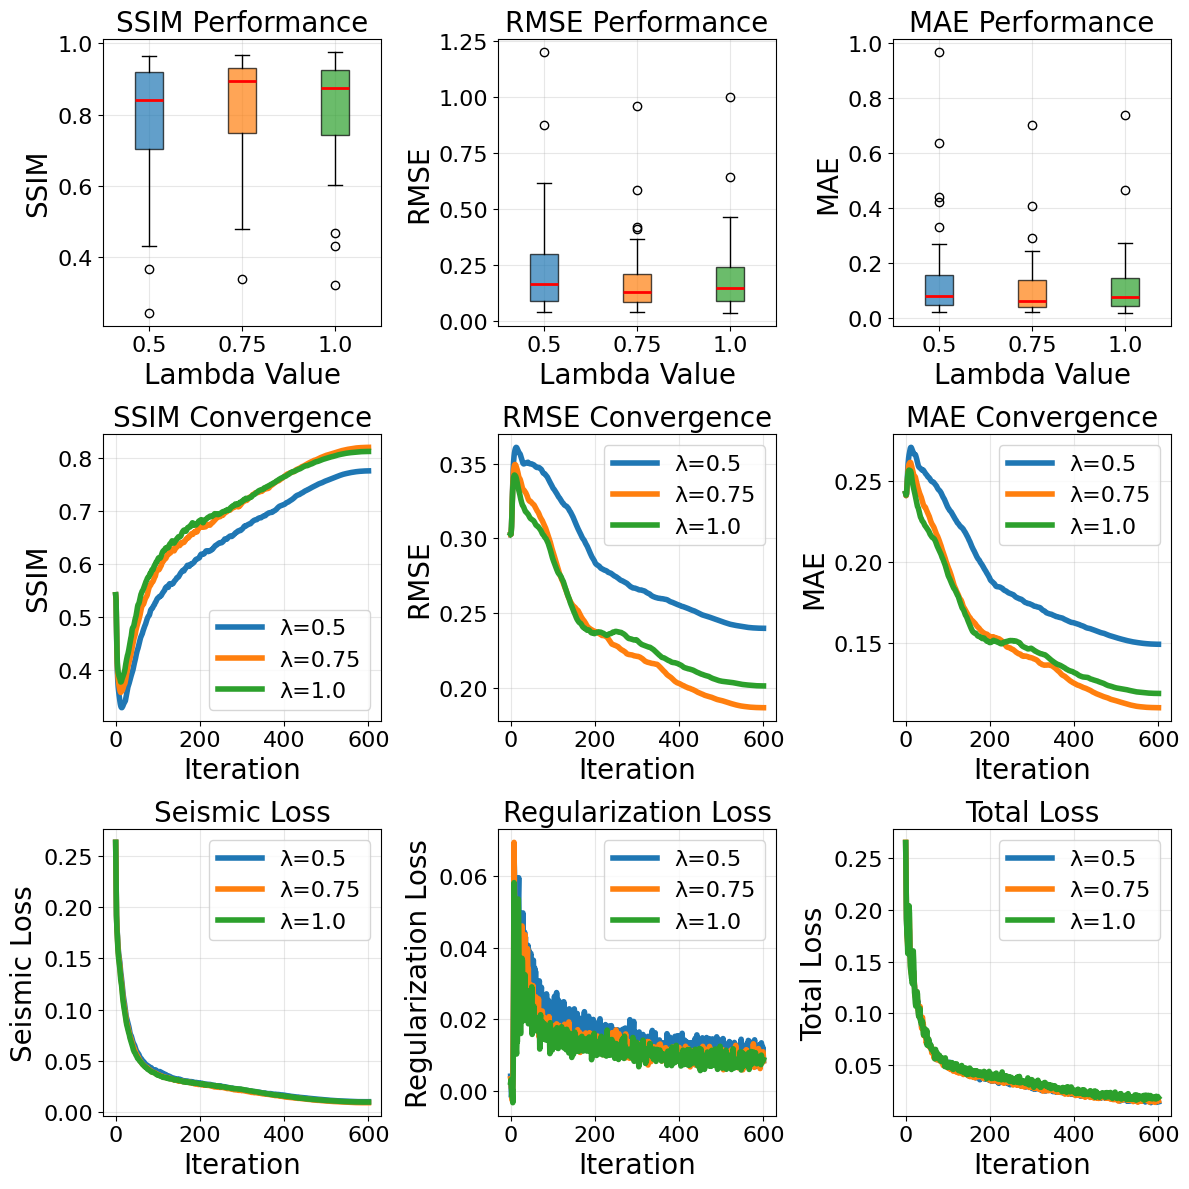

PerformanceSummary:

Lambda = 0.5:
  SSIM: Mean = 0.7765, Std = 0.1777
  RMSE: Mean = 0.2398, Std = 0.2372
  MAE: Mean = 0.1494, Std = 0.1841
  SEISMIC_LOSS: Mean = 0.0102, Std = 0.0133
  REG_LOSS: Mean = 0.0084, Std = 0.0122

Lambda = 0.75:
  SSIM: Mean = 0.8210, Std = 0.1551
  RMSE: Mean = 0.1866, Std = 0.1740
  MAE: Mean = 0.1104, Std = 0.1263
  SEISMIC_LOSS: Mean = 0.0092, Std = 0.0128
  REG_LOSS: Mean = 0.0084, Std = 0.0095

Lambda = 1.0:
  SSIM: Mean = 0.8133, Std = 0.1552
  RMSE: Mean = 0.2012, Std = 0.1791
  MAE: Mean = 0.1192, Std = 0.1303
  SEISMIC_LOSS: Mean = 0.0098, Std = 0.0127
  REG_LOSS: Mean = 0.0087, Std = 0.0081

Best Final Performance:
Best Final SSIM: Lambda = 0.75
Best Final RMSE: Lambda = 0.75
Best Final MAE: Lambda = 0.75

Plotting final models for first sample (CF_0) across lambda values...


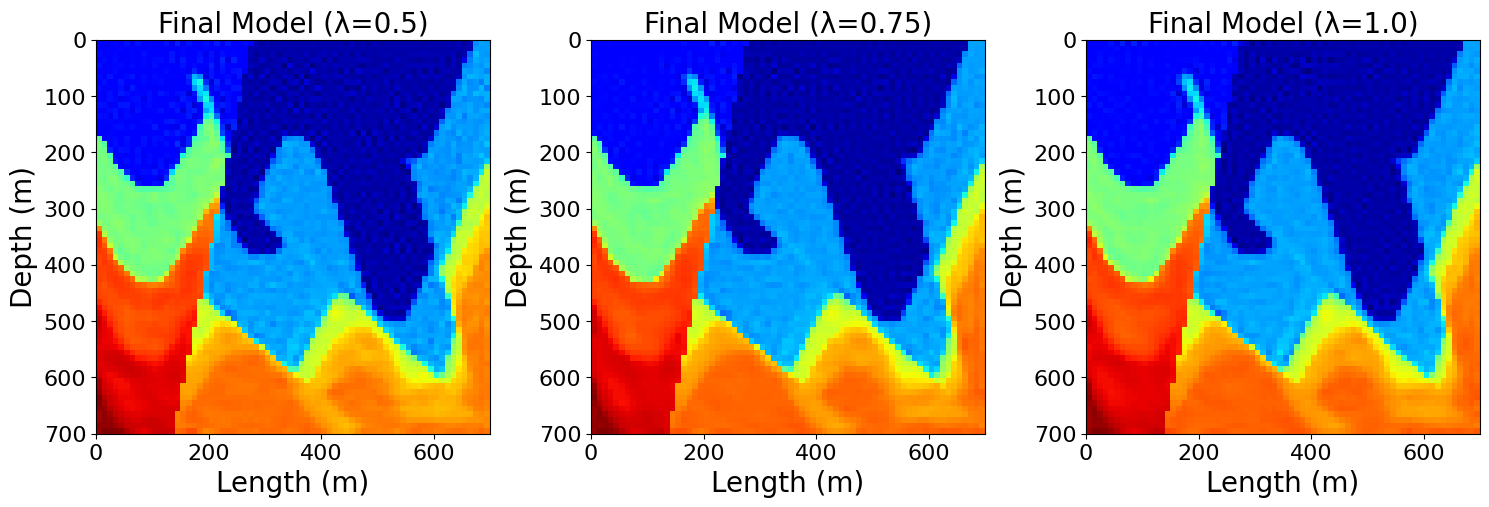

In [40]:
# Plot for the diffusion reg_lambda tuning
import os
import pickle
import matplotlib.pyplot as plt
import glob
import numpy as np

root_path = "experiment_result/"
Scenarios = ["2B"]
exp_phase = ["tuning"]
fed_method = ["FedAvgM"]
reg_method = ["Diffusion"]
reg_lambda = ['0.5', '0.75', '1.0']
data_family_list = ['CF', 'CV', 'FF', 'FV']
fontsize = 20
labelsize = 16
# Dictionary to store metrics for each lambda
metrics_by_lambda = {}

for i, lambda_val in enumerate(reg_lambda):
    result_path = root_path + exp_phase[0] + "_" + fed_method[0] + "_" + reg_method[0] + "_" + lambda_val + "_" + Scenarios[0] + "_*"
    result_path = glob.glob(result_path)[0]
    
    # Initialize metrics storage for this lambda
    metrics_by_lambda[lambda_val] = {
        'ssim': {'final': [], 'iterations': {}},  # final values + per-iteration values
        'rmse': {'final': [], 'iterations': {}},
        'mae': {'final': [], 'iterations': {}},
        'seismic_loss': {'final': [], 'iterations': {}},
        'reg_loss': {'final': [], 'iterations': {}}
    }
    result_count = 0
    for data_family in data_family_list:
        for j in range(10):
            instance_path = result_path + "/" + data_family + "_" + str(j) + "_result.pkl"
            try:
                with open(instance_path, "rb") as f:
                    result = pickle.load(f)
                
                # Extract metrics from the history
                if 'history' in result:
                    eval_metrics = result['history'].metrics_centralized
                    
                    # Extract metrics for each iteration
                    for metric_name in ['ssim', 'rmse', 'mae', 'seismic_loss', 'reg_loss']:
                        if metric_name in eval_metrics:
                            # Store final value (last iteration)
                            final_value = eval_metrics[metric_name][-1][1]  # Last tuple's value
                            metrics_by_lambda[lambda_val][metric_name]['final'].append(final_value)
                            
                            # Store values for each iteration
                            for round_num, metric_value in eval_metrics[metric_name]:
                                if round_num not in metrics_by_lambda[lambda_val][metric_name]['iterations']:
                                    metrics_by_lambda[lambda_val][metric_name]['iterations'][round_num] = []
                                metrics_by_lambda[lambda_val][metric_name]['iterations'][round_num].append(metric_value)
            
            except FileNotFoundError:
                print(f"File not found: {instance_path}")
            except Exception as e:
                print(f"Error loading {instance_path}: {e}")

print(metrics_by_lambda['0.75']['ssim']['final'][0])
print(metrics_by_lambda['0.75']['mae']['final'][0])
print(metrics_by_lambda['0.75']['rmse']['final'][0])


# Create three rows of plots: Box plots + Convergence plots + Loss plots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Define consistent colors for each lambda
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
lambda_colors = dict(zip(reg_lambda, colors))

# Plot 1: Box plots for Performance(SSIM, RMSE, MAE)
for i, metric in enumerate(['ssim', 'rmse', 'mae']):
    # Get final values for each lambda
    final_data = [metrics_by_lambda[lambda_val][metric]['final'] for lambda_val in reg_lambda]
    
    # Create box plot with custom colors
    bp = axes[0, i].boxplot(final_data, tick_labels=reg_lambda, patch_artist=True,medianprops=dict(linewidth=2, color='red'))
    
    # Set colors for each box to match line plot colors
    for patch, lambda_val in zip(bp['boxes'], reg_lambda):
        patch.set_facecolor(lambda_colors[lambda_val])
        patch.set_alpha(0.7)
    
    axes[0, i].set_title(f'{metric.upper()} Performance', fontsize=fontsize)
    axes[0, i].set_xlabel('Lambda Value', fontsize=fontsize)
    axes[0, i].set_ylabel(metric.upper(), fontsize=fontsize)
    axes[0, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[0, i].grid(True, alpha=0.3)

# Plot 2: Line plots for convergence (SSIM, RMSE, MAE)
for i, metric in enumerate(['ssim', 'rmse', 'mae']):
    # Get iteration data for each lambda
    for lambda_val in reg_lambda:
        if metrics_by_lambda[lambda_val][metric]['iterations']:
            # Sort iterations and calculate mean across samples for each iteration
            iterations = sorted(metrics_by_lambda[lambda_val][metric]['iterations'].keys())
            means = [np.mean(metrics_by_lambda[lambda_val][metric]['iterations'][iter_num]) for iter_num in iterations]
            
            # Plot line for this lambda (no markers, just lines)
            if metric == 'ssim':
                # Higher is better for SSIM
                axes[1, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
            else:
                # Lower is better for RMSE/MAE
                axes[1, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
    
    axes[1, i].set_title(f'{metric.upper()} Convergence', fontsize=fontsize)
    axes[1, i].set_xlabel('Iteration', fontsize=fontsize)
    axes[1, i].set_ylabel(metric.upper(), fontsize=fontsize)
    axes[1, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[1, i].legend(fontsize=labelsize)
    axes[1, i].grid(True, alpha=0.3)

# Plot 3: Line plots for losses (Total Loss, Seismic Loss, Reg Loss)
loss_metrics = ['seismic_loss', 'reg_loss']
loss_titles = ['Seismic Loss', 'Regularization Loss']

for i, (metric, title) in enumerate(zip(loss_metrics, loss_titles)):
    # Get iteration data for each lambda
    for lambda_val in reg_lambda:
        if metrics_by_lambda[lambda_val][metric]['iterations']:
            # Sort iterations and calculate mean across samples for each iteration
            iterations = sorted(metrics_by_lambda[lambda_val][metric]['iterations'].keys())
            means = [np.mean(metrics_by_lambda[lambda_val][metric]['iterations'][iter_num]) for iter_num in iterations]
            
            # Plot line for this lambda (no markers, just lines)
            axes[2, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
    
    axes[2, i].set_title(f'{title}', fontsize=fontsize)
    axes[2, i].set_xlabel('Iteration', fontsize=fontsize)
    axes[2, i].set_ylabel(title, fontsize=fontsize)
    axes[2, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[2, i].legend(fontsize=labelsize)
    axes[2, i].grid(True, alpha=0.3)

# Plot Total Loss (calculated as seismic_loss + reg_lambda * reg_loss)
for lambda_val in reg_lambda:
    if (metrics_by_lambda[lambda_val]['seismic_loss']['iterations'] and 
        metrics_by_lambda[lambda_val]['reg_loss']['iterations']):
        
        # Get common iterations
        seismic_iterations = set(metrics_by_lambda[lambda_val]['seismic_loss']['iterations'].keys())
        reg_iterations = set(metrics_by_lambda[lambda_val]['reg_loss']['iterations'].keys())
        common_iterations = sorted(seismic_iterations.intersection(reg_iterations))
        
        if common_iterations:
            total_loss_means = []
            for iter_num in common_iterations:
                seismic_mean = np.mean(metrics_by_lambda[lambda_val]['seismic_loss']['iterations'][iter_num])
                reg_mean = np.mean(metrics_by_lambda[lambda_val]['reg_loss']['iterations'][iter_num])
                lambda_val_float = float(lambda_val)
                total_loss = seismic_mean + lambda_val_float * reg_mean
                total_loss_means.append(total_loss)
            
            # Plot total loss line
            axes[2, 2].plot(common_iterations, total_loss_means, 
                           label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)

axes[2, 2].set_title('Total Loss', fontsize=fontsize)
axes[2, 2].set_xlabel('Iteration', fontsize=fontsize)
axes[2, 2].set_ylabel('Total Loss', fontsize=fontsize)
axes[2, 2].tick_params(axis='both', which='major', labelsize=labelsize)
axes[2, 2].legend(fontsize=labelsize)
axes[2, 2].grid(True, alpha=0.3)

import os
os.makedirs("plots/exp_result/tuning", exist_ok=True)

plt.tight_layout()
plt.savefig("plots/exp_result/tuning/tuning_diff_lambda.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for final performance
print("PerformanceSummary:")
print("=" * 60)
for lambda_val in reg_lambda:
    print(f"\nLambda = {lambda_val}:")
    for metric in ['ssim', 'rmse', 'mae', 'seismic_loss', 'reg_loss']:
        if metrics_by_lambda[lambda_val][metric]['final']:
            final_values = metrics_by_lambda[lambda_val][metric]['final']
            print(f"  {metric.upper()}: Mean = {np.mean(final_values):.4f}, Std = {np.std(final_values):.4f}")

# Find best performing lambda for final performance
print("\nBest Final Performance:")
print("=" * 60)
best_ssim_lambda = max(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['ssim']['final']))
best_rmse_lambda = min(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['rmse']['final']))
best_mae_lambda = min(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['mae']['final']))

print(f"Best Final SSIM: Lambda = {best_ssim_lambda}")
print(f"Best Final RMSE: Lambda = {best_rmse_lambda}")
print(f"Best Final MAE: Lambda = {best_mae_lambda}")

# Plot final models for the first sample (CF_0) across different lambda values
print("\nPlotting final models for first sample (CF_0) across lambda values...")

# Get the first sample results for each lambda
fig, axes = plt.subplots(1, len(reg_lambda), figsize=(5*len(reg_lambda), 5))

for i, lambda_val in enumerate(reg_lambda):
    result_path = root_path + exp_phase[0] + "_" + fed_method[0] + "_" + reg_method[0] + "_" + lambda_val + "_" + Scenarios[0] + "_*"
    result_path = glob.glob(result_path)[0]
    
    # Load the first sample (CF_0)
    instance_path = result_path + "/CF_0_result.pkl"
    try:
        with open(instance_path, "rb") as f:
            result = pickle.load(f)
        
        # Extract the final model
        if 'final_model' in result:
            final_model = result['final_model']
            
            # Plot the model (assuming it's a 2D array, take the first slice if 4D)
            if final_model.ndim == 4:
                # If 4D, take the first slice
                model_2d = final_model[0, 0, :, :]
            elif final_model.ndim == 3:
                # If 3D, take the first slice
                model_2d = final_model[0, :, :]
            else:
                # If 2D, use as is
                model_2d = final_model
            
            # Create the plot with proper aspect ratio and physical dimensions
            # Make it perfect square and set physical dimensions
            im = axes[i].imshow(model_2d[1:-1,1:-1], cmap='jet', aspect='equal', 
                               extent=[0, 700, 700, 0])  # [xmin, xmax, ymax, ymin] for imshow
            
            axes[i].set_title(f'Final Model (λ={lambda_val})', fontsize=fontsize)
            axes[i].set_xlabel('Length (m)', fontsize=fontsize)
            axes[i].set_ylabel('Depth (m)', fontsize=fontsize)
            axes[i].tick_params(axis='both', which='major', labelsize=labelsize)
            
            
        else:
            axes[i].text(0.5, 0.5, 'No final model found', ha='center', va='center', transform=axes[i].transAxes, fontsize=fontsize)
            axes[i].set_title(f'λ={lambda_val} (No data)', fontsize=fontsize)
            
    except Exception as e:
        axes[i].text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=axes[i].transAxes, fontsize=fontsize)
        axes[i].set_title(f'λ={lambda_val} (Error)', fontsize=fontsize)

plt.tight_layout()
plt.savefig("plots/exp_result/tuning/tuning_diff_lambda_model.png", dpi=300, bbox_inches='tight')
plt.show()



[0.6974221467971802, 0.5937426686286926, 0.28116634488105774, 0.8617986440658569, 0.5477815270423889, 0.5038216710090637, 0.45068004727363586, 0.4315776824951172, 0.45458170771598816, 0.3174973130226135, 0.6339561939239502, 0.5421828031539917, 0.30919718742370605, 0.441940575838089, 0.3894488513469696, 0.4780580997467041, 0.5586059093475342, 0.3837934136390686, 0.42604008316993713, 0.3400425314903259, 0.8707119822502136, 0.4738684296607971, 0.49826669692993164, 0.3580206632614136, 0.45340245962142944, 0.3749936521053314, 0.6703680753707886, 0.5585287809371948, 0.4008091390132904, 0.5488297939300537, 0.6032091379165649, 0.32786595821380615, 0.7752935290336609, 0.4949367344379425, 0.5871999859809875, 0.6340987682342529, 0.56845623254776, 0.5645676255226135, 0.636292576789856, 0.8104459643363953]
[0.6463189125061035, 0.5236802697181702, 0.28040850162506104, 0.8715695738792419, 0.5605530142784119, 0.5010572671890259, 0.47060447931289673, 0.4241676330566406, 0.4445389211177826, 0.4086175560

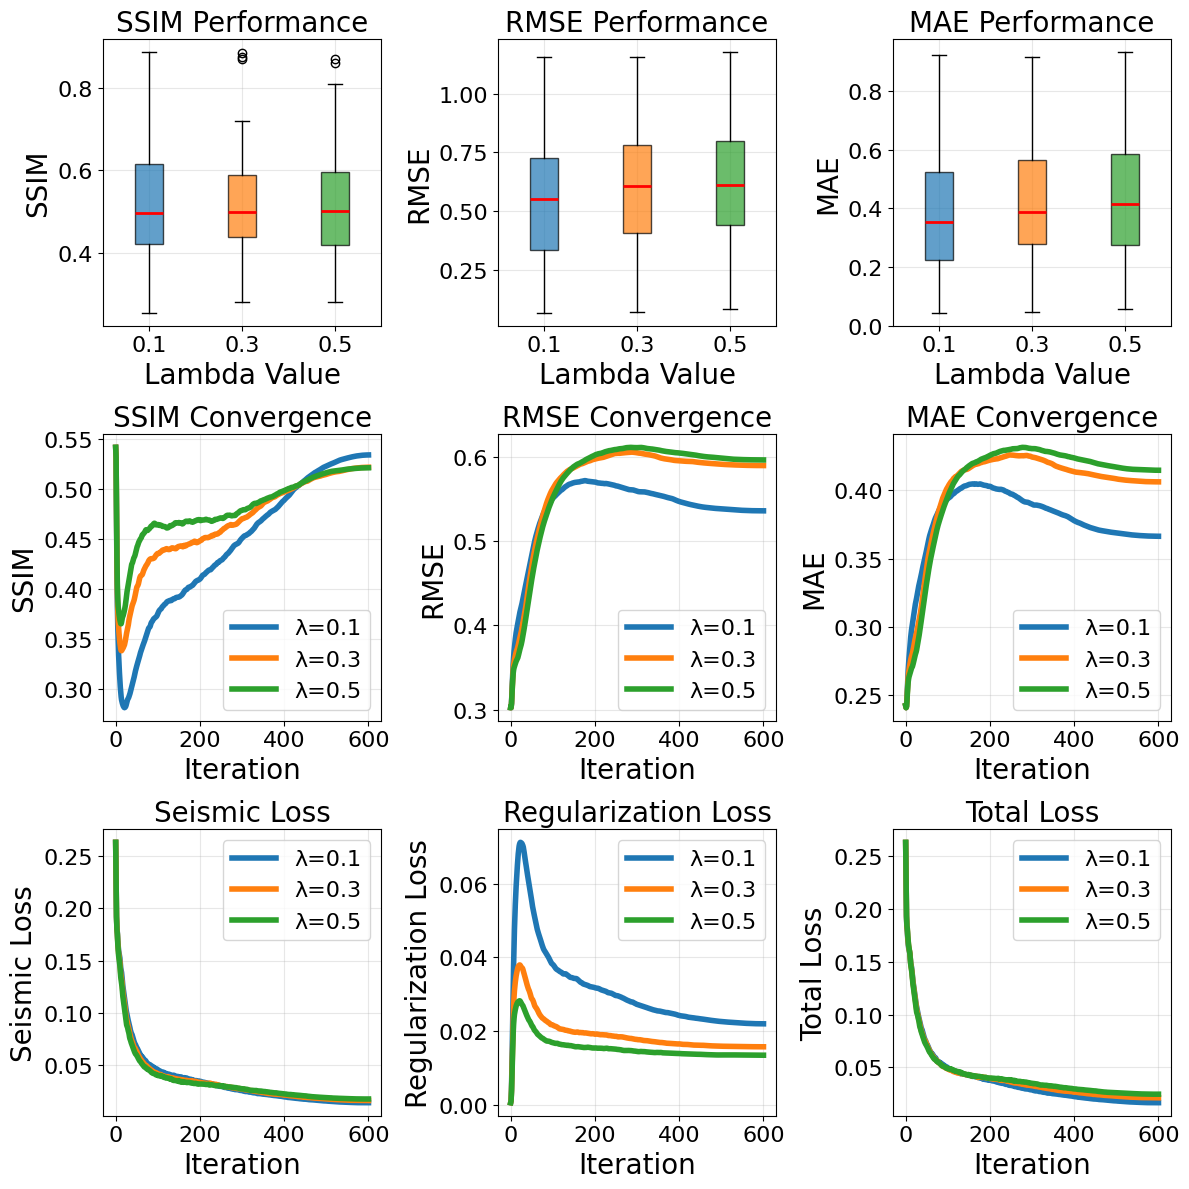

PerformanceSummary:

Lambda = 0.1:
  SSIM: Mean = 0.5342, Std = 0.1573
  RMSE: Mean = 0.5358, Std = 0.2724
  MAE: Mean = 0.3664, Std = 0.2072
  SEISMIC_LOSS: Mean = 0.0144, Std = 0.0115
  REG_LOSS: Mean = 0.0220, Std = 0.0123

Lambda = 0.3:
  SSIM: Mean = 0.5219, Std = 0.1428
  RMSE: Mean = 0.5895, Std = 0.2626
  MAE: Mean = 0.4063, Std = 0.2021
  SEISMIC_LOSS: Mean = 0.0165, Std = 0.0110
  REG_LOSS: Mean = 0.0157, Std = 0.0090

Lambda = 0.5:
  SSIM: Mean = 0.5213, Std = 0.1466
  RMSE: Mean = 0.5961, Std = 0.2566
  MAE: Mean = 0.4148, Std = 0.2015
  SEISMIC_LOSS: Mean = 0.0179, Std = 0.0107
  REG_LOSS: Mean = 0.0134, Std = 0.0074

Best Final Performance:
Best Final SSIM: Lambda = 0.1
Best Final RMSE: Lambda = 0.1
Best Final MAE: Lambda = 0.1

Plotting final models for first sample (CF_0) across lambda values...


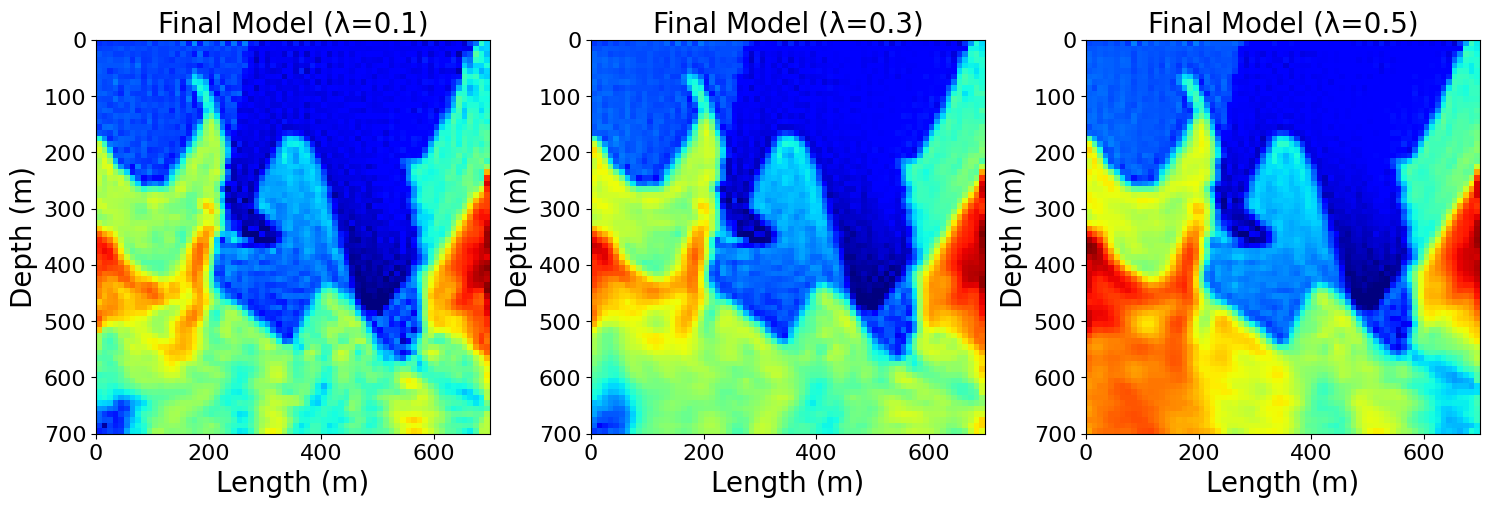

In [30]:
# Plot for the tiknov reg_lambda tuning
root_path = "experiment_result/"
Scenarios = ["2B"]
exp_phase = ["tuning"]
fed_method = ["FedAvgM"]
reg_method = ["Tiknov"]
reg_lambda = ['0.1', '0.3', '0.5']
data_family_list = ['CF', 'CV', 'FF', 'FV']
fontsize = 20
labelsize = 16
# Dictionary to store metrics for each lambda
metrics_by_lambda = {}

for i, lambda_val in enumerate(reg_lambda):
    result_path = root_path + exp_phase[0] + "_" + fed_method[0] + "_" + reg_method[0] + "_" + lambda_val + "_" + Scenarios[0] + "_*"
    result_path = glob.glob(result_path)[0]
    
    # Initialize metrics storage for this lambda
    metrics_by_lambda[lambda_val] = {
        'ssim': {'final': [], 'iterations': {}},  # final values + per-iteration values
        'rmse': {'final': [], 'iterations': {}},
        'mae': {'final': [], 'iterations': {}},
        'seismic_loss': {'final': [], 'iterations': {}},
        'reg_loss': {'final': [], 'iterations': {}}
    }
    
    for data_family in data_family_list:
        for j in range(10):
            instance_path = result_path + "/" + data_family + "_" + str(j) + "_result.pkl"
            try:
                with open(instance_path, "rb") as f:
                    result = pickle.load(f)
                
                # Extract metrics from the history
                if 'history' in result:
                    eval_metrics = result['history'].metrics_centralized
                    
                    # Extract metrics for each iteration
                    for metric_name in ['ssim', 'rmse', 'mae', 'seismic_loss', 'reg_loss']:
                        if metric_name in eval_metrics:
                            # Store final value (last iteration)
                            final_value = eval_metrics[metric_name][-1][1]  # Last tuple's value
                            metrics_by_lambda[lambda_val][metric_name]['final'].append(final_value)
                            
                            # Store values for each iteration
                            for round_num, metric_value in eval_metrics[metric_name]:
                                if round_num not in metrics_by_lambda[lambda_val][metric_name]['iterations']:
                                    metrics_by_lambda[lambda_val][metric_name]['iterations'][round_num] = []
                                metrics_by_lambda[lambda_val][metric_name]['iterations'][round_num].append(metric_value)

            except FileNotFoundError:
                print(f"File not found: {instance_path}")
            except Exception as e:
                print(f"Error loading {instance_path}: {e}")
print(metrics_by_lambda['0.5']['ssim']['final'])
print(metrics_by_lambda['0.3']['ssim']['final'])
print(metrics_by_lambda['0.1']['ssim']['final'])
# Create three rows of plots: Box plots + Convergence plots + Loss plots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Define consistent colors for each lambda
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
lambda_colors = dict(zip(reg_lambda, colors))

# Plot 1: Box plots for Performance(SSIM, RMSE, MAE)
for i, metric in enumerate(['ssim', 'rmse', 'mae']):
    # Get final values for each lambda
    final_data = [metrics_by_lambda[lambda_val][metric]['final'] for lambda_val in reg_lambda]
    
    # Create box plot with custom colors
    bp = axes[0, i].boxplot(final_data, tick_labels=reg_lambda, patch_artist=True,medianprops=dict(linewidth=2, color='red'))
    
    # Set colors for each box to match line plot colors
    for patch, lambda_val in zip(bp['boxes'], reg_lambda):
        patch.set_facecolor(lambda_colors[lambda_val])
        patch.set_alpha(0.7)
    
    axes[0, i].set_title(f'{metric.upper()} Performance', fontsize=fontsize)
    axes[0, i].set_xlabel('Lambda Value', fontsize=fontsize)
    axes[0, i].set_ylabel(metric.upper(), fontsize=fontsize)
    axes[0, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[0, i].grid(True, alpha=0.3)

# Plot 2: Line plots for convergence (SSIM, RMSE, MAE)
for i, metric in enumerate(['ssim', 'rmse', 'mae']):
    # Get iteration data for each lambda
    for lambda_val in reg_lambda:
        if metrics_by_lambda[lambda_val][metric]['iterations']:
            # Sort iterations and calculate mean across samples for each iteration
            iterations = sorted(metrics_by_lambda[lambda_val][metric]['iterations'].keys())
            means = [np.mean(metrics_by_lambda[lambda_val][metric]['iterations'][iter_num]) for iter_num in iterations]
            
            # Plot line for this lambda (no markers, just lines)
            if metric == 'ssim':
                # Higher is better for SSIM
                axes[1, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
            else:
                # Lower is better for RMSE/MAE
                axes[1, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
    
    axes[1, i].set_title(f'{metric.upper()} Convergence', fontsize=fontsize)
    axes[1, i].set_xlabel('Iteration', fontsize=fontsize)
    axes[1, i].set_ylabel(metric.upper(), fontsize=fontsize)
    axes[1, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[1, i].legend(fontsize=labelsize)
    axes[1, i].grid(True, alpha=0.3)

# Plot 3: Line plots for losses (Total Loss, Seismic Loss, Reg Loss)
loss_metrics = ['seismic_loss', 'reg_loss']
loss_titles = ['Seismic Loss', 'Regularization Loss']

for i, (metric, title) in enumerate(zip(loss_metrics, loss_titles)):
    # Get iteration data for each lambda
    for lambda_val in reg_lambda:
        if metrics_by_lambda[lambda_val][metric]['iterations']:
            # Sort iterations and calculate mean across samples for each iteration
            iterations = sorted(metrics_by_lambda[lambda_val][metric]['iterations'].keys())
            means = [np.mean(metrics_by_lambda[lambda_val][metric]['iterations'][iter_num]) for iter_num in iterations]
            
            # Plot line for this lambda (no markers, just lines)
            axes[2, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
    
    axes[2, i].set_title(f'{title}', fontsize=fontsize)
    axes[2, i].set_xlabel('Iteration', fontsize=fontsize)
    axes[2, i].set_ylabel(title, fontsize=fontsize)
    axes[2, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[2, i].legend(fontsize=labelsize)
    axes[2, i].grid(True, alpha=0.3)

# Plot Total Loss (calculated as seismic_loss + reg_lambda * reg_loss)
for lambda_val in reg_lambda:
    if (metrics_by_lambda[lambda_val]['seismic_loss']['iterations'] and 
        metrics_by_lambda[lambda_val]['reg_loss']['iterations']):
        
        # Get common iterations
        seismic_iterations = set(metrics_by_lambda[lambda_val]['seismic_loss']['iterations'].keys())
        reg_iterations = set(metrics_by_lambda[lambda_val]['reg_loss']['iterations'].keys())
        common_iterations = sorted(seismic_iterations.intersection(reg_iterations))
        
        if common_iterations:
            total_loss_means = []
            for iter_num in common_iterations:
                seismic_mean = np.mean(metrics_by_lambda[lambda_val]['seismic_loss']['iterations'][iter_num])
                reg_mean = np.mean(metrics_by_lambda[lambda_val]['reg_loss']['iterations'][iter_num])
                lambda_val_float = float(lambda_val)
                total_loss = seismic_mean + lambda_val_float * reg_mean
                total_loss_means.append(total_loss)
            
            # Plot total loss line
            axes[2, 2].plot(common_iterations, total_loss_means, 
                           label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)

axes[2, 2].set_title('Total Loss', fontsize=fontsize)
axes[2, 2].set_xlabel('Iteration', fontsize=fontsize)
axes[2, 2].set_ylabel('Total Loss', fontsize=fontsize)
axes[2, 2].tick_params(axis='both', which='major', labelsize=labelsize)
axes[2, 2].legend(fontsize=labelsize)
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plots/exp_result/tuning/tuning_tikhonov_lambda.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for final performance
print("PerformanceSummary:")
print("=" * 60)
for lambda_val in reg_lambda:
    print(f"\nLambda = {lambda_val}:")
    for metric in ['ssim', 'rmse', 'mae', 'seismic_loss', 'reg_loss']:
        if metrics_by_lambda[lambda_val][metric]['final']:
            final_values = metrics_by_lambda[lambda_val][metric]['final']
            print(f"  {metric.upper()}: Mean = {np.mean(final_values):.4f}, Std = {np.std(final_values):.4f}")

# Find best performing lambda for final performance
print("\nBest Final Performance:")
print("=" * 60)
best_ssim_lambda = max(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['ssim']['final']))
best_rmse_lambda = min(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['rmse']['final']))
best_mae_lambda = min(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['mae']['final']))

print(f"Best Final SSIM: Lambda = {best_ssim_lambda}")
print(f"Best Final RMSE: Lambda = {best_rmse_lambda}")
print(f"Best Final MAE: Lambda = {best_mae_lambda}")

# Plot final models for the first sample (CF_0) across different lambda values
print("\nPlotting final models for first sample (CF_0) across lambda values...")

# Get the first sample results for each lambda
fig, axes = plt.subplots(1, len(reg_lambda), figsize=(5*len(reg_lambda), 5))

for i, lambda_val in enumerate(reg_lambda):
    result_path = root_path + exp_phase[0] + "_" + fed_method[0] + "_" + reg_method[0] + "_" + lambda_val + "_" + Scenarios[0] + "_*"
    result_path = glob.glob(result_path)[0]
    
    # Load the first sample (CF_0)
    instance_path = result_path + "/CF_0_result.pkl"
    try:
        with open(instance_path, "rb") as f:
            result = pickle.load(f)
        
        # Extract the final model
        if 'final_model' in result:
            final_model = result['final_model']
            
            # Plot the model (assuming it's a 2D array, take the first slice if 4D)
            if final_model.ndim == 4:
                # If 4D, take the first slice
                model_2d = final_model[0, 0, :, :]
            elif final_model.ndim == 3:
                # If 3D, take the first slice
                model_2d = final_model[0, :, :]
            else:
                # If 2D, use as is
                model_2d = final_model
            
            # Create the plot with proper aspect ratio and physical dimensions
            # Make it perfect square and set physical dimensions
            im = axes[i].imshow(model_2d[1:-1,1:-1], cmap='jet', aspect='equal', 
                               extent=[0, 700, 700, 0])  # [xmin, xmax, ymax, ymin] for imshow
            
            axes[i].set_title(f'Final Model (λ={lambda_val})', fontsize=fontsize)
            axes[i].set_xlabel('Length (m)', fontsize=fontsize)
            axes[i].set_ylabel('Depth (m)', fontsize=fontsize)
            axes[i].tick_params(axis='both', which='major', labelsize=labelsize)
            
            
        else:
            axes[i].text(0.5, 0.5, 'No final model found', ha='center', va='center', transform=axes[i].transAxes, fontsize=fontsize)
            axes[i].set_title(f'λ={lambda_val} (No data)', fontsize=fontsize)
            
    except Exception as e:
        axes[i].text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=axes[i].transAxes, fontsize=fontsize)
        axes[i].set_title(f'λ={lambda_val} (Error)', fontsize=fontsize)

plt.tight_layout()
plt.savefig("plots/exp_result/tuning/tuning_tikhonov_lambda_model.png", dpi=300, bbox_inches='tight')
plt.show()

[0.7475388646125793, 0.870823085308075, 0.5582784414291382, 0.8491265773773193, 0.7486701011657715, 0.6563194990158081, 0.7164767980575562, 0.6548922657966614, 0.7047364115715027, 0.6433441042900085, 0.769940972328186, 0.6575566530227661, 0.6525055766105652, 0.6437007784843445, 0.6798810958862305, 0.5980627536773682, 0.7856976389884949, 0.8428826332092285, 0.5568512082099915, 0.8126716017723083, 0.8843500018119812, 0.8675432205200195, 0.8482587337493896, 0.48161715269088745, 0.8325154185295105, 0.8375529050827026, 0.8339906930923462, 0.9568731784820557, 0.7725652456283569, 0.9176322221755981, 0.8370428085327148, 0.8825182318687439, 1.0000325441360474, 0.9328780770301819, 0.9038307070732117, 0.9988608956336975, 0.9754645824432373, 0.9999868273735046, 0.9347550868988037, 1.000023365020752]
[0.8151222467422485, 0.8868395090103149, 0.6022639870643616, 0.8670351505279541, 0.7603036165237427, 0.6525292992591858, 0.7534806728363037, 0.6628735065460205, 0.7313754558563232, 0.7061115503311157, 

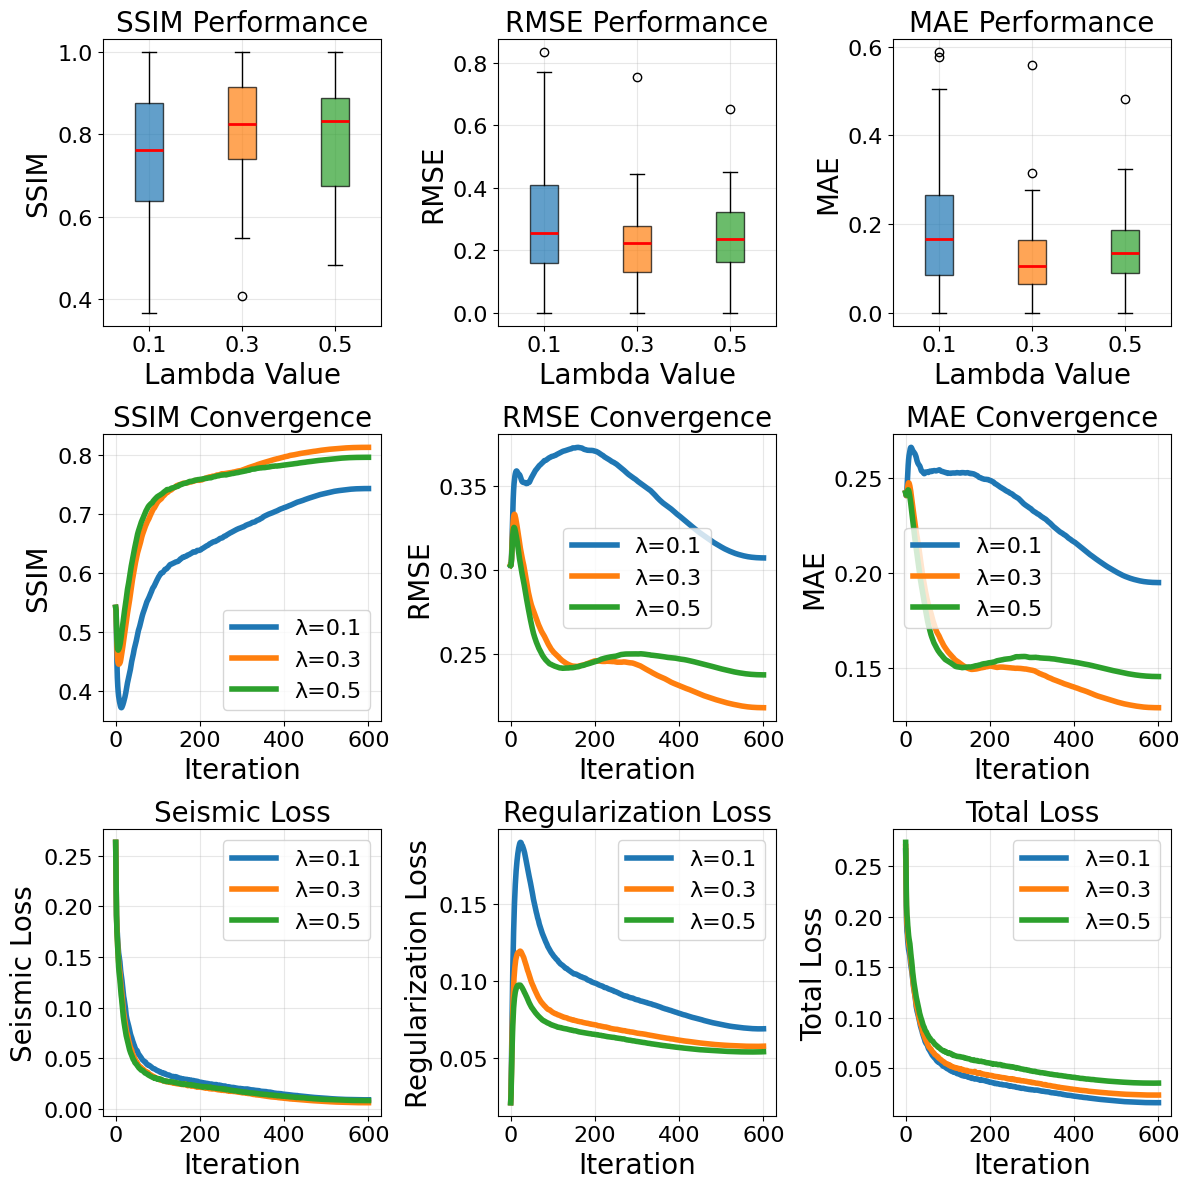

PerformanceSummary:

Lambda = 0.1:
  SSIM: Mean = 0.7432, Std = 0.1686
  RMSE: Mean = 0.3071, Std = 0.2037
  MAE: Mean = 0.1950, Std = 0.1496
  SEISMIC_LOSS: Mean = 0.0090, Std = 0.0112
  REG_LOSS: Mean = 0.0689, Std = 0.0324

Lambda = 0.3:
  SSIM: Mean = 0.8131, Std = 0.1354
  RMSE: Mean = 0.2177, Std = 0.1462
  MAE: Mean = 0.1290, Std = 0.1051
  SEISMIC_LOSS: Mean = 0.0062, Std = 0.0062
  REG_LOSS: Mean = 0.0576, Std = 0.0246

Lambda = 0.5:
  SSIM: Mean = 0.7962, Std = 0.1360
  RMSE: Mean = 0.2373, Std = 0.1381
  MAE: Mean = 0.1454, Std = 0.0998
  SEISMIC_LOSS: Mean = 0.0083, Std = 0.0073
  REG_LOSS: Mean = 0.0541, Std = 0.0224

Best Final Performance:
Best Final SSIM: Lambda = 0.3
Best Final RMSE: Lambda = 0.3
Best Final MAE: Lambda = 0.3

Plotting final models for first sample (CF_0) across lambda values...


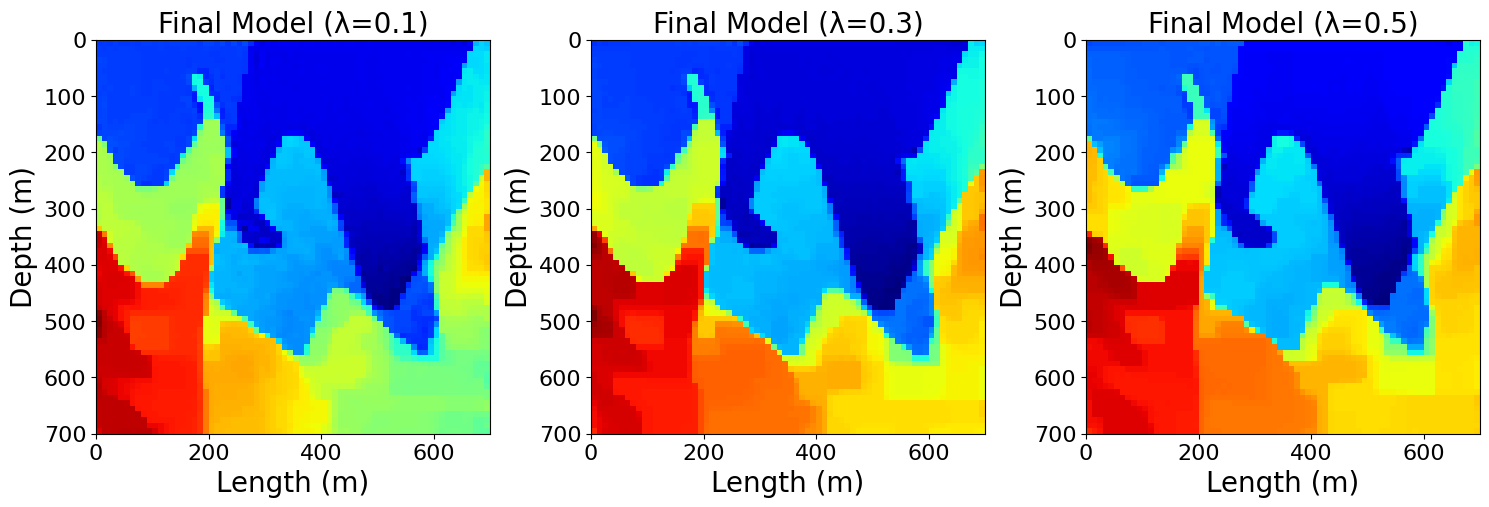

In [31]:
# Plot for the tv reg_lambda tuning
root_path = "experiment_result/"
Scenarios = ["2B"]
exp_phase = ["tuning"]
fed_method = ["FedAvgM"]
reg_method = ["Total_Variation"]
reg_lambda = ['0.1', '0.3', '0.5']
data_family_list = ['CF', 'CV', 'FF', 'FV']
fontsize = 20
labelsize = 16
# Dictionary to store metrics for each lambda
metrics_by_lambda = {}

for i, lambda_val in enumerate(reg_lambda):
    result_path = root_path + exp_phase[0] + "_" + fed_method[0] + "_" + reg_method[0] + "_" + lambda_val + "_" + Scenarios[0] + "_*"
    result_path = glob.glob(result_path)[0]
    
    # Initialize metrics storage for this lambda
    metrics_by_lambda[lambda_val] = {
        'ssim': {'final': [], 'iterations': {}},  # final values + per-iteration values
        'rmse': {'final': [], 'iterations': {}},
        'mae': {'final': [], 'iterations': {}},
        'seismic_loss': {'final': [], 'iterations': {}},
        'reg_loss': {'final': [], 'iterations': {}}
    }
    
    for data_family in data_family_list:
        for j in range(10):
            instance_path = result_path + "/" + data_family + "_" + str(j) + "_result.pkl"
            try:
                with open(instance_path, "rb") as f:
                    result = pickle.load(f)
                
                # Extract metrics from the history
                if 'history' in result:
                    eval_metrics = result['history'].metrics_centralized
                    
                    # Extract metrics for each iteration
                    for metric_name in ['ssim', 'rmse', 'mae', 'seismic_loss', 'reg_loss']:
                        if metric_name in eval_metrics:
                            # Store final value (last iteration)
                            final_value = eval_metrics[metric_name][-1][1]  # Last tuple's value
                            metrics_by_lambda[lambda_val][metric_name]['final'].append(final_value)
                            
                            # Store values for each iteration
                            for round_num, metric_value in eval_metrics[metric_name]:
                                if round_num not in metrics_by_lambda[lambda_val][metric_name]['iterations']:
                                    metrics_by_lambda[lambda_val][metric_name]['iterations'][round_num] = []
                                metrics_by_lambda[lambda_val][metric_name]['iterations'][round_num].append(metric_value)

            except FileNotFoundError:
                print(f"File not found: {instance_path}")
            except Exception as e:
                print(f"Error loading {instance_path}: {e}")
print(metrics_by_lambda['0.5']['ssim']['final'])
print(metrics_by_lambda['0.3']['ssim']['final'])
print(metrics_by_lambda['0.1']['ssim']['final'])
# Create three rows of plots: Box plots + Convergence plots + Loss plots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Define consistent colors for each lambda
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
lambda_colors = dict(zip(reg_lambda, colors))

# Plot 1: Box plots for Performance(SSIM, RMSE, MAE)
for i, metric in enumerate(['ssim', 'rmse', 'mae']):
    # Get final values for each lambda
    final_data = [metrics_by_lambda[lambda_val][metric]['final'] for lambda_val in reg_lambda]
    
    # Create box plot with custom colors
    bp = axes[0, i].boxplot(final_data, tick_labels=reg_lambda, patch_artist=True,medianprops=dict(linewidth=2, color='red'))
    
    # Set colors for each box to match line plot colors
    for patch, lambda_val in zip(bp['boxes'], reg_lambda):
        patch.set_facecolor(lambda_colors[lambda_val])
        patch.set_alpha(0.7)
    
    axes[0, i].set_title(f'{metric.upper()} Performance', fontsize=fontsize)
    axes[0, i].set_xlabel('Lambda Value', fontsize=fontsize)
    axes[0, i].set_ylabel(metric.upper(), fontsize=fontsize)
    axes[0, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[0, i].grid(True, alpha=0.3)

# Plot 2: Line plots for convergence (SSIM, RMSE, MAE)
for i, metric in enumerate(['ssim', 'rmse', 'mae']):
    # Get iteration data for each lambda
    for lambda_val in reg_lambda:
        if metrics_by_lambda[lambda_val][metric]['iterations']:
            # Sort iterations and calculate mean across samples for each iteration
            iterations = sorted(metrics_by_lambda[lambda_val][metric]['iterations'].keys())
            means = [np.mean(metrics_by_lambda[lambda_val][metric]['iterations'][iter_num]) for iter_num in iterations]
            
            # Plot line for this lambda (no markers, just lines)
            if metric == 'ssim':
                # Higher is better for SSIM
                axes[1, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
            else:
                # Lower is better for RMSE/MAE
                axes[1, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
    
    axes[1, i].set_title(f'{metric.upper()} Convergence', fontsize=fontsize)
    axes[1, i].set_xlabel('Iteration', fontsize=fontsize)
    axes[1, i].set_ylabel(metric.upper(), fontsize=fontsize)
    axes[1, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[1, i].legend(fontsize=labelsize)
    axes[1, i].grid(True, alpha=0.3)

# Plot 3: Line plots for losses (Total Loss, Seismic Loss, Reg Loss)
loss_metrics = ['seismic_loss', 'reg_loss']
loss_titles = ['Seismic Loss', 'Regularization Loss']

for i, (metric, title) in enumerate(zip(loss_metrics, loss_titles)):
    # Get iteration data for each lambda
    for lambda_val in reg_lambda:
        if metrics_by_lambda[lambda_val][metric]['iterations']:
            # Sort iterations and calculate mean across samples for each iteration
            iterations = sorted(metrics_by_lambda[lambda_val][metric]['iterations'].keys())
            means = [np.mean(metrics_by_lambda[lambda_val][metric]['iterations'][iter_num]) for iter_num in iterations]
            
            # Plot line for this lambda (no markers, just lines)
            axes[2, i].plot(iterations, means, label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)
    
    axes[2, i].set_title(f'{title}', fontsize=fontsize)
    axes[2, i].set_xlabel('Iteration', fontsize=fontsize)
    axes[2, i].set_ylabel(title, fontsize=fontsize)
    axes[2, i].tick_params(axis='both', which='major', labelsize=labelsize)
    axes[2, i].legend(fontsize=labelsize)
    axes[2, i].grid(True, alpha=0.3)

# Plot Total Loss (calculated as seismic_loss + reg_lambda * reg_loss)
for lambda_val in reg_lambda:
    if (metrics_by_lambda[lambda_val]['seismic_loss']['iterations'] and 
        metrics_by_lambda[lambda_val]['reg_loss']['iterations']):
        
        # Get common iterations
        seismic_iterations = set(metrics_by_lambda[lambda_val]['seismic_loss']['iterations'].keys())
        reg_iterations = set(metrics_by_lambda[lambda_val]['reg_loss']['iterations'].keys())
        common_iterations = sorted(seismic_iterations.intersection(reg_iterations))
        
        if common_iterations:
            total_loss_means = []
            for iter_num in common_iterations:
                seismic_mean = np.mean(metrics_by_lambda[lambda_val]['seismic_loss']['iterations'][iter_num])
                reg_mean = np.mean(metrics_by_lambda[lambda_val]['reg_loss']['iterations'][iter_num])
                lambda_val_float = float(lambda_val)
                total_loss = seismic_mean + lambda_val_float * reg_mean
                total_loss_means.append(total_loss)
            
            # Plot total loss line
            axes[2, 2].plot(common_iterations, total_loss_means, 
                           label=f'λ={lambda_val}', color=lambda_colors[lambda_val], linewidth=4)

axes[2, 2].set_title('Total Loss', fontsize=fontsize)
axes[2, 2].set_xlabel('Iteration', fontsize=fontsize)
axes[2, 2].set_ylabel('Total Loss', fontsize=fontsize)
axes[2, 2].tick_params(axis='both', which='major', labelsize=labelsize)
axes[2, 2].legend(fontsize=labelsize)
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plots/exp_result/tuning/tuning_tv_lambda.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for final performance
print("PerformanceSummary:")
print("=" * 60)
for lambda_val in reg_lambda:
    print(f"\nLambda = {lambda_val}:")
    for metric in ['ssim', 'rmse', 'mae', 'seismic_loss', 'reg_loss']:
        if metrics_by_lambda[lambda_val][metric]['final']:
            final_values = metrics_by_lambda[lambda_val][metric]['final']
            print(f"  {metric.upper()}: Mean = {np.mean(final_values):.4f}, Std = {np.std(final_values):.4f}")

# Find best performing lambda for final performance
print("\nBest Final Performance:")
print("=" * 60)
best_ssim_lambda = max(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['ssim']['final']))
best_rmse_lambda = min(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['rmse']['final']))
best_mae_lambda = min(reg_lambda, key=lambda x: np.mean(metrics_by_lambda[x]['mae']['final']))

print(f"Best Final SSIM: Lambda = {best_ssim_lambda}")
print(f"Best Final RMSE: Lambda = {best_rmse_lambda}")
print(f"Best Final MAE: Lambda = {best_mae_lambda}")

# Plot final models for the first sample (CF_0) across different lambda values
print("\nPlotting final models for first sample (CF_0) across lambda values...")

# Get the first sample results for each lambda
fig, axes = plt.subplots(1, len(reg_lambda), figsize=(5*len(reg_lambda), 5))

for i, lambda_val in enumerate(reg_lambda):
    result_path = root_path + exp_phase[0] + "_" + fed_method[0] + "_" + reg_method[0] + "_" + lambda_val + "_" + Scenarios[0] + "_*"
    result_path = glob.glob(result_path)[0]
    
    # Load the first sample (CF_0)
    instance_path = result_path + "/CF_0_result.pkl"
    try:
        with open(instance_path, "rb") as f:
            result = pickle.load(f)
        
        # Extract the final model
        if 'final_model' in result:
            final_model = result['final_model']
            
            # Plot the model (assuming it's a 2D array, take the first slice if 4D)
            if final_model.ndim == 4:
                # If 4D, take the first slice
                model_2d = final_model[0, 0, :, :]
            elif final_model.ndim == 3:
                # If 3D, take the first slice
                model_2d = final_model[0, :, :]
            else:
                # If 2D, use as is
                model_2d = final_model
            
            # Create the plot with proper aspect ratio and physical dimensions
            # Make it perfect square and set physical dimensions
            im = axes[i].imshow(model_2d[1:-1,1:-1], cmap='jet', aspect='equal', 
                               extent=[0, 700, 700, 0])  # [xmin, xmax, ymax, ymin] for imshow
            
            axes[i].set_title(f'Final Model (λ={lambda_val})', fontsize=fontsize)
            axes[i].set_xlabel('Length (m)', fontsize=fontsize)
            axes[i].set_ylabel('Depth (m)', fontsize=fontsize)
            axes[i].tick_params(axis='both', which='major', labelsize=labelsize)
            
            
        else:
            axes[i].text(0.5, 0.5, 'No final model found', ha='center', va='center', transform=axes[i].transAxes, fontsize=fontsize)
            axes[i].set_title(f'λ={lambda_val} (No data)', fontsize=fontsize)
            
    except Exception as e:
        axes[i].text(0.5, 0.5, f'Error: {str(e)}', ha='center', va='center', transform=axes[i].transAxes, fontsize=fontsize)
        axes[i].set_title(f'λ={lambda_val} (Error)', fontsize=fontsize)

plt.tight_layout()
plt.savefig("plots/exp_result/tuning/tuning_tv_lambda_model.png", dpi=300, bbox_inches='tight')
plt.show()

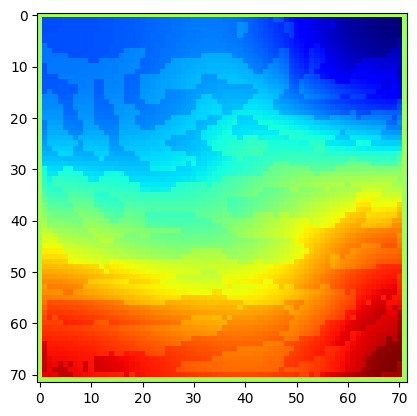

[0.6279456615447998]


In [39]:
c_path = "experiment_result/Centralized_Baseline_Diffusion_0.75_2B_20250822_064825/FF_8_result.pkl"
with open(c_path, "rb") as f:
    result = pickle.load(f)

final_model = result['final_model']

plt.imshow(final_model[0, 0, :, :], cmap='jet')
plt.show()
print(result['ssim'])

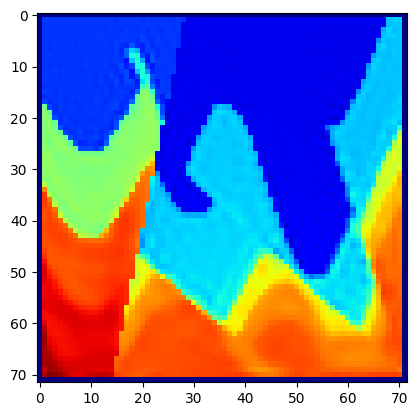

0.03849303349852562
0.06586958911197305


In [45]:
c_path = "c_result.pkl"
with open(c_path, "rb") as f:
    result = pickle.load(f)

final_model = result['final_model']

plt.imshow(final_model[0, 0, :, :].detach().to('cpu').numpy(), cmap='jet')
plt.show()
print(result['current_MAE'][-1])
print(result['current_RMSE'][-1])